# Standard Neural DAG Circuit Generator

This notebook explores a basic directed-acyclic graph (DAG) neural circuit generator, whose goal is to find circuits which accurately predict while also optimizing for minimal circuit geometry (edge and node count).

## TODO: Write more here to explain the experiment and its results

In [40]:
import sys
from pathlib import Path

notebook_dir = Path.cwd()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

print(f"Project root added to sys.path: {str(project_root)}")
print(f"Current sys.path: {sys.path}")

import numpy
import cktgen
import random
import typing
import itertools
import dataclasses
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

Project root added to sys.path: c:\quack_pot\science\cktgen
Current sys.path: ['c:\\quack_pot\\science\\cktgen', 'c:\\quack_pot\\science\\cktgen', 'c:\\quack_pot\\science\\cktgen', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.3312.0_x64__qbz5n2kfra8p0\\python313.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.3312.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.3312.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.3312.0_x64__qbz5n2kfra8p0', 'c:\\quack_pot\\science\\cktgen\\.notebooks', '', 'c:\\quack_pot\\science\\cktgen\\.notebooks\\Lib\\site-packages']


In [41]:
def literal_combinations(literal_count: int) -> list[list[float]]:
    return [list(map(float, p)) for p in itertools.product([0, 1], repeat=literal_count)]

def createNeuralDAG(
        input_data: list[list[float]],
        output_data: list[list[float]],
        max_hidden_node_count: int = 5,
        epochs: int = 25000,
        learning_rate: float = 0.05,
        lambda_edges: float = 1e-2,
        lambda_nodes: float = 1e-2,
        node_strength_sharpness: float = 10.0,
    ) -> cktgen.models.StandardNeuralDAG:
    assert len(input_data) == len(output_data), "Malformed input-output pairs!"

    dag_model: cktgen.models.StandardNeuralDAG = cktgen.models.StandardNeuralDAG(
        cktgen.models.StandardNeuralDAGCreateInfo(
            input_node_count=len(input_data[0]) if len(input_data) > 0 else 0,
            hidden_node_count=max_hidden_node_count,
            output_node_count=len(output_data[0]) if len(output_data) > 0 else 0,
        )
    )

    dag_model.train(cktgen.models.StandardNeuralDAGTrainInfo(
        input_data=input_data,
        output_data=output_data,
        epochs=epochs,
        epoch_print_cadence=epochs + 1, # ? Effectivly Removes Printing
        learning_rate=learning_rate,
        lambda_edges=lambda_edges,
        lambda_nodes=lambda_nodes,
        node_strength_sharpness=node_strength_sharpness,
    ))

    return dag_model

def testAccuracyNeuralDAG(
    test_name: str,
    input_data: list[list[float]],
    output_data: list[list[float]],
    model: cktgen.models.StandardNeuralDAG,
    cleanOutput: typing.Callable[[float], float] = lambda val: float(round(val)),
    compare_epsilon: float = 1e-6,
) -> float:
    assert len(input_data) == len(output_data), "Malformed input-output pairs!"

    total_tests: float = float(len(input_data))
    if total_tests <= 0.0:
        return 1.0
    
    correct_results: float = 0.0
    
    def getCleanValue(raw_val: float, true_val: float) -> float:
        nonlocal correct_results
        clean: float = cleanOutput(raw_val)

        if abs(true_val - clean) <= compare_epsilon:
            correct_results += 1.0

        return clean

    with open(f"{test_name}_truth_table.txt", "w") as truth_table_file:
        truth_table_file.write(f"{test_name} Truth Table\n------------------------------\n(Inputs) - [(Raw, Hard-Threshold, Truth), ...]\n")

        for x, y in zip(input_data, output_data):
            output: list[float] = model.evaluate(x)

            input_str: str = ', '.join(f"{in_val:.2f}" for in_val in x)
            output_str: str = ', '.join(f"({pred_val:.2f}, {getCleanValue(pred_val, true_val):.2f}, {true_val:.2f})" for true_val, pred_val in zip(y, output))

            truth_table_file.write(f"({input_str}) - [{output_str}]\n")

    return correct_results / total_tests

def visualizeNeuralDAG(
    test_name: str,
    model: cktgen.models.StandardNeuralDAG,
    edge_prune_threshold: float = 1e-1,
) -> cktgen.graphs.NeuralGraph:
    dag: cktgen.graphs.NeuralGraph = model.extractDAG(edge_prune_threshold)
    dag.renderGraph(f"{test_name}_dag")

    return dag

In [42]:
@dataclasses.dataclass
class TestDataNeuralDAG:
    test_name: str
    accuracy: float
    computation_node_count: int

__cur_test_data: list[TestDataNeuralDAG] = []

def pushTestNeuralDAG(test_name: str, input_data: list[list[float]], output_data: list[list[float]]) -> None:
    print(f"Testing {test_name} Neural DAG...")
    model: cktgen.models.StandardNeuralDAG = createNeuralDAG(input_data, output_data)
    dag: cktgen.graphs.NeuralGraph = visualizeNeuralDAG(test_name, model)

    accuracy: float = testAccuracyNeuralDAG(test_name, input_data, output_data, model)
    
    hidden_node_count: int = dag.getHiddenNodeCount()
    output_node_count: int = dag.getOutputNodeCount()
    computation_node_count: int = hidden_node_count + output_node_count

    test_data: TestDataNeuralDAG = TestDataNeuralDAG(test_name, accuracy, computation_node_count)
    __cur_test_data.append(test_data)

def processTestData(test_batch_name: str) -> None:
    if len(__cur_test_data) <= 0:
        return
    
    sorted_data: list[TestDataNeuralDAG] = sorted(__cur_test_data, key=lambda datum: (datum.computation_node_count, datum.accuracy))

    test_names: list[str] = [datum.test_name for datum in sorted_data]
    accuracies: list[float] = [datum.accuracy for datum in sorted_data]
    computation_node_counts: list[int] = [datum.computation_node_count for datum in sorted_data]

    __cur_test_data.clear()

    name_range = numpy.arange(len(test_names))
    name_width: float = 0.8 / max(len(test_names), 1)

    _, ax1 = plt.subplots()

    ax1.bar(name_range - name_width/2, computation_node_counts, name_width, color="steelblue", label="Node Count")
    ax1.set_ylabel("Computable Node Count")
    ax1.set_xlabel("Model Name")
    ax1.set_xticks(name_range)
    ax1.set_xticklabels(test_names, rotation=45, ha="right")
    ax1.yaxis.set_major_locator(tick.MaxNLocator(integer=True))

    ax2 = ax1.twinx()
    ax2.bar(name_range + name_width/2, accuracies, name_width, color="darkorange", label="Accuracy")
    ax2.set_ylabel("Accuracy (%)")

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1, -0.05))

    plt.title("Model Complexity vs Accuracy")
    plt.tight_layout()
    plt.savefig(f"{test_batch_name}_complexity_vs_accuracy_dual_axis.png")

Testing Common 2-Input Boolean Functions
------------------------------
Testing 2_input_const_false Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 12.1069)
Testing 2_input_const_true Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 0.6127)
Testing 2_input_and Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 8.5882)
Testing 2_input_or Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 3.0299)
Testing 2_input_nand Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 3.4732)
Testing 2_input_nor Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 6.0906)
Testing 2_input_xor Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 6.4682)


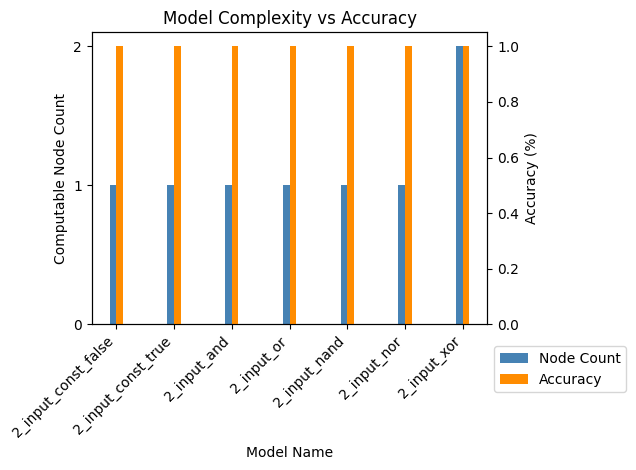

In [43]:
two_literal_pairs: list[list[float]] = literal_combinations(2)

print("Testing Common 2-Input Boolean Functions\n------------------------------")
pushTestNeuralDAG("2_input_const_false", two_literal_pairs, [[0.0] for _ in two_literal_pairs])
pushTestNeuralDAG("2_input_const_true",  two_literal_pairs, [[1.0] for _ in two_literal_pairs])
pushTestNeuralDAG("2_input_and",         two_literal_pairs, [[0.0], [0.0], [0.0], [1.0]])
pushTestNeuralDAG("2_input_or",          two_literal_pairs, [[0.0], [1.0], [1.0], [1.0]])
pushTestNeuralDAG("2_input_nand",        two_literal_pairs, [[1.0], [1.0], [1.0], [0.0]])
pushTestNeuralDAG("2_input_nor",         two_literal_pairs, [[1.0], [0.0], [0.0], [0.0]])
pushTestNeuralDAG("2_input_xor",         two_literal_pairs, [[0.0], [1.0], [1.0], [0.0]])
processTestData("2_input_boolean_gates")

In [44]:
def testRandomBooleanFunctions(literal_count: int, random_test_count: int) -> None:
    assert literal_count < 11, "Literal count would cause memory usage to exceed 1GB!"

    truth_table_size: int = 2**literal_count
    literal_pairs: list[list[float]] = literal_combinations(literal_count)

    print(f"Testing Random {literal_count}-Input Boolean Functions\n------------------------------")
    for test_idx in range(random_test_count):
        truth_table: int = random.getrandbits(truth_table_size)

        pushTestNeuralDAG(
            f"{literal_count}_input_random_boolean_function_test_{test_idx}",
            literal_pairs,
            [[float((truth_table >> i) & 0b1)] for i in range(truth_table_size)],
        )

    processTestData(f"{literal_count}_input_random_boolean_functions")

Testing Random 3-Input Boolean Functions
------------------------------
Testing 3_input_random_boolean_function_test_0 Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 19.0584)
Testing 3_input_random_boolean_function_test_1 Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 11.2218)
Testing 3_input_random_boolean_function_test_2 Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 13.4089)
Testing 3_input_random_boolean_function_test_3 Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 25.4575)
Testing 3_input_random_boolean_function_test_4 Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 8.2730)
Testing 3_input_random_boolean_function_test_5 Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 10.0247)
Testing 3_input_random_boolean_function_test_6 Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 10.9959)
Testing 3_input_random_boolean_function_test_7 Neural DAG...
StaticSparseDAG Training (Epoch = 0; Loss = 7.8855)
Testing 3_input_ra

KeyboardInterrupt: 

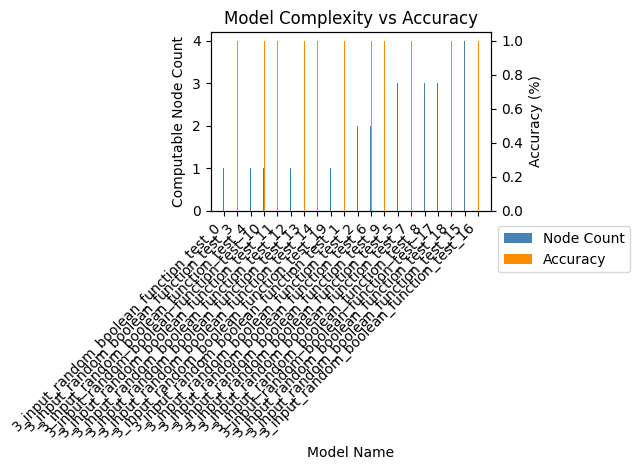

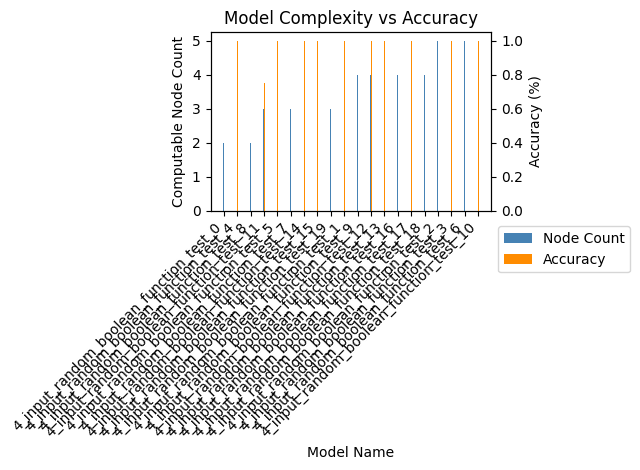

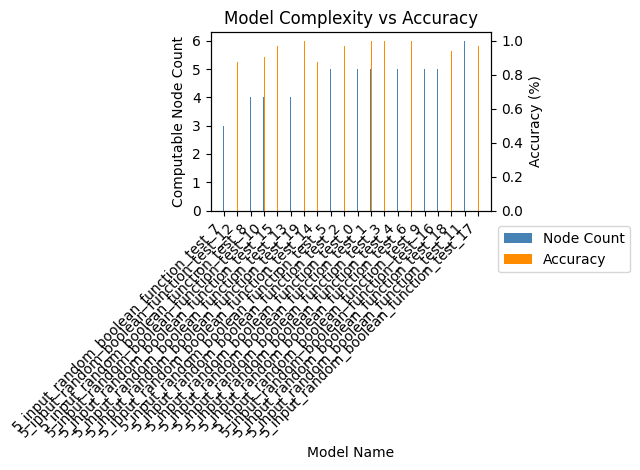

In [45]:
min_random_function_literal_count: int = 3
max_random_function_literal_count: int = 8
random_function_test_iterations: int = 20

for literal_count in range(min_random_function_literal_count, max_random_function_literal_count + 1):
    testRandomBooleanFunctions(literal_count, random_function_test_iterations)